In [19]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
import kagglehub
import random
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
plt.style.use('ggplot')

In [20]:
gpu = tf.config.experimental.list_physical_devices('GPU')
if gpu:
    try:
        tf.config.experimental.set_memory_growth(gpu[0], True)
    except RuntimeError as e:
        print(e)

In [21]:
path = kagglehub.dataset_download("mostafaabla/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/academic-city-university/.cache/kagglehub/datasets/mostafaabla/garbage-classification/versions/1


In [22]:
selected_classes = ['cardboard', 'metal', 'paper', 'plastic', 'trash', 'white-glass', 'brown-glass', 'green-glass']
main_dir = os.path.join(path, 'garbage_classification')

In [23]:
image_paths = []
image_labels = []
for label in selected_classes:
    class_dir = os.path.join(main_dir, label)
    for img_file in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img_file))
        if label == 'white-glass' or 'green-glass' or 'brown-glass':
            label = label.replace('white-glass', 'glass')
            label = label.replace('green-glass', 'glass')
            label = label.replace('brown-glass', 'glass')
        image_labels.append(label)

In [24]:
selected_classes = ['cardboard', 'metal', 'paper', 'plastic', 'trash', 'glass']

In [25]:
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)
print("Total images:", len(image_paths))
print("Total labels:", len(image_labels))

Total images: 6283
Total labels: 6283


In [26]:
# Create a DataFrame
df = pd.DataFrame({'image_path': image_paths, 'label': image_labels})
print(df.tail())

df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame

                                             image_path  label
6278  /Users/academic-city-university/.cache/kaggleh...  glass
6279  /Users/academic-city-university/.cache/kaggleh...  glass
6280  /Users/academic-city-university/.cache/kaggleh...  glass
6281  /Users/academic-city-university/.cache/kaggleh...  glass
6282  /Users/academic-city-university/.cache/kaggleh...  glass


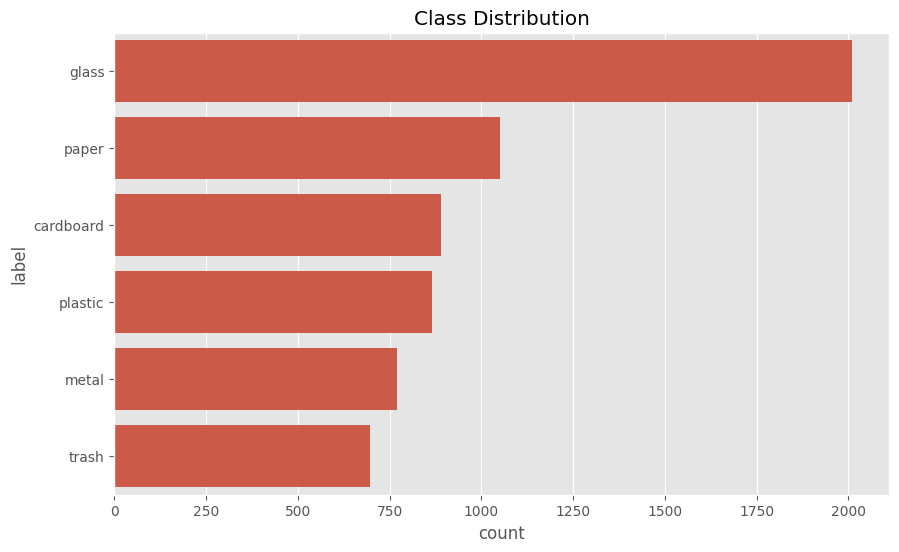

In [27]:
# Check class distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title('Class Distribution')
plt.show()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6283 entries, 0 to 6282
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  6283 non-null   object
 1   label       6283 non-null   object
dtypes: object(2)
memory usage: 98.3+ KB


In [29]:
df['label'].value_counts()

label
glass        2011
paper        1050
cardboard     891
plastic       865
metal         769
trash         697
Name: count, dtype: int64

In [30]:
df[200:1300]

,image_path,label
200,/Users/academic-city-university/.cache/kaggleh...,glass
201,/Users/academic-city-university/.cache/kaggleh...,glass
202,/Users/academic-city-university/.cache/kaggleh...,metal
203,/Users/academic-city-university/.cache/kaggleh...,paper
204,/Users/academic-city-university/.cache/kaggleh...,glass
...,...,...
1295,/Users/academic-city-university/.cache/kaggleh...,trash
1296,/Users/academic-city-university/.cache/kaggleh...,paper
1297,/Users/academic-city-university/.cache/kaggleh...,paper
1298,/Users/academic-city-university/.cache/kaggleh...,paper


In [31]:
#Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
print("Training set size:", len(train_df))  
print("Validation set size:", len(val_df))
print("Testing set size:", len(test_df))
train_df['label'].value_counts()
val_df['label'].value_counts()
test_df['label'].value_counts()

Training set size: 4020
Validation set size: 1006
Testing set size: 1257


label
glass        402
paper        210
cardboard    178
plastic      173
metal        154
trash        140
Name: count, dtype: int64

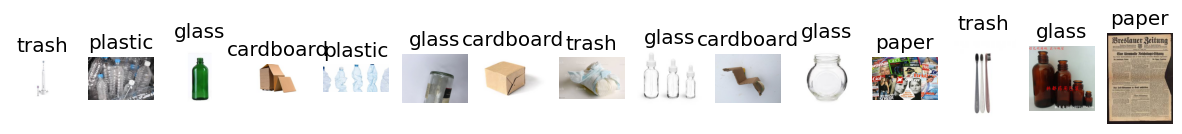

In [32]:
#Data Exploration
def plot_sample_images(df, num_samples=15):
    plt.figure(figsize=(15, 10))
    sampled_df = df.sample(num_samples)
    for i, (index, row) in enumerate(sampled_df.iterrows()):
        img = load_img(row['image_path'])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(row['label'])
        plt.axis('off')
    plt.show()
plot_sample_images(df)

In [33]:
#Image Processing and Data Augmentation
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4020 validated image filenames belonging to 6 classes.


Found 1006 validated image filenames belonging to 6 classes.
Found 1257 validated image filenames belonging to 6 classes.


In [34]:
#Modeling
with tf.device('/GPU:0'):
    model = Sequential([

        MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg'
        ),
        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.05),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(len(selected_classes), activation='softmax')
    ])

In [35]:
preTrainedModel = model.layers[0]
for layer in preTrainedModel.layers[:-4]:
    layer.trainable = False

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,110 (9.27 MB)

 Trainable params: 585,030 (2.23 MB)

 Non-trainable params: 1,846,080 (7.04 MB)

In [37]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=40
)

Epoch 1/40


/opt/anaconda3/envs/clean_credit/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 220ms/step - accuracy: 0.7050 - loss: 0.8625 - val_accuracy: 0.8231 - val_loss: 0.5041
Epoch 2/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.8381 - loss: 0.4767 - val_accuracy: 0.8569 - val_loss: 0.4430
Epoch 3/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.8657 - loss: 0.3895 - val_accuracy: 0.8946 - val_loss: 0.3528
Epoch 4/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 218ms/step - accuracy: 0.8831 - loss: 0.3359 - val_accuracy: 0.8837 - val_loss: 0.4044
Epoch 5/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.8920 - loss: 0.3018 - val_accuracy: 0.8797 - val_loss: 0.3661
Epoch 6/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.9137 - loss: 0.2622 - val_accuracy: 0.8867 - val_loss: 0.3886
Epoch 7/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.9167 - loss: 0.2366 - val_accuracy: 0.8817 - val_loss: 0.4133
Epoch 8/40
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.9269 - loss: 0.2179 - val

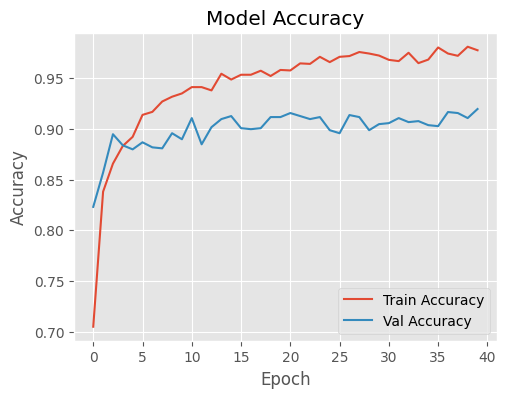

In [38]:
#Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
# Evaluate the model    
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test Accuracy: {test_accuracy:.4f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.9356 - loss: 0.2668
Test Accuracy: 0.9356


In [40]:
# Generate predictions
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step


In [41]:
# Classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   cardboard       0.98      0.93      0.95       178
       glass       0.94      0.96      0.95       402
       metal       0.87      0.89      0.88       154
       paper       0.92      0.97      0.94       210
     plastic       0.92      0.87      0.89       173
       trash       0.99      0.96      0.97       140

    accuracy                           0.94      1257
   macro avg       0.94      0.93      0.93      1257
weighted avg       0.94      0.94      0.94      1257



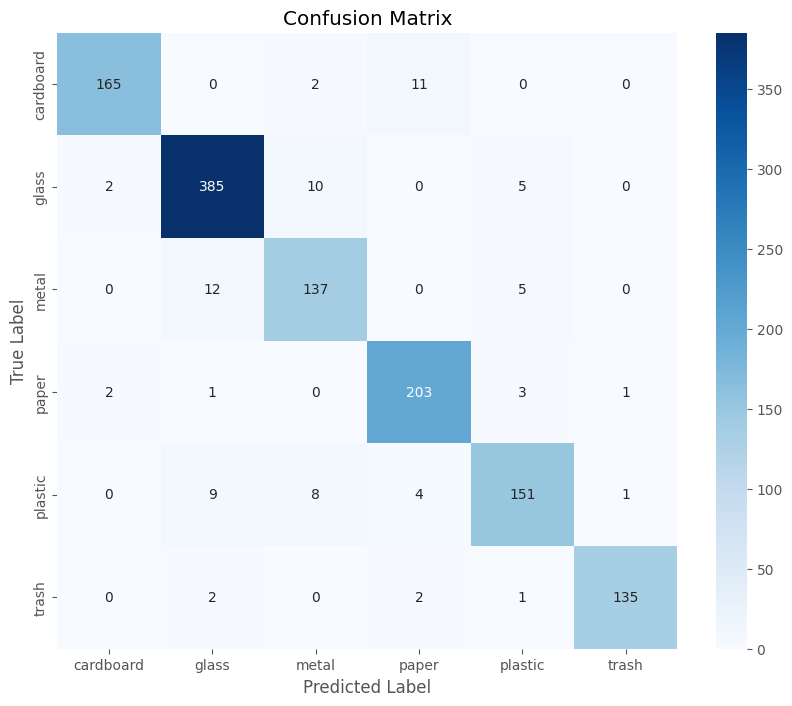

In [42]:
# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

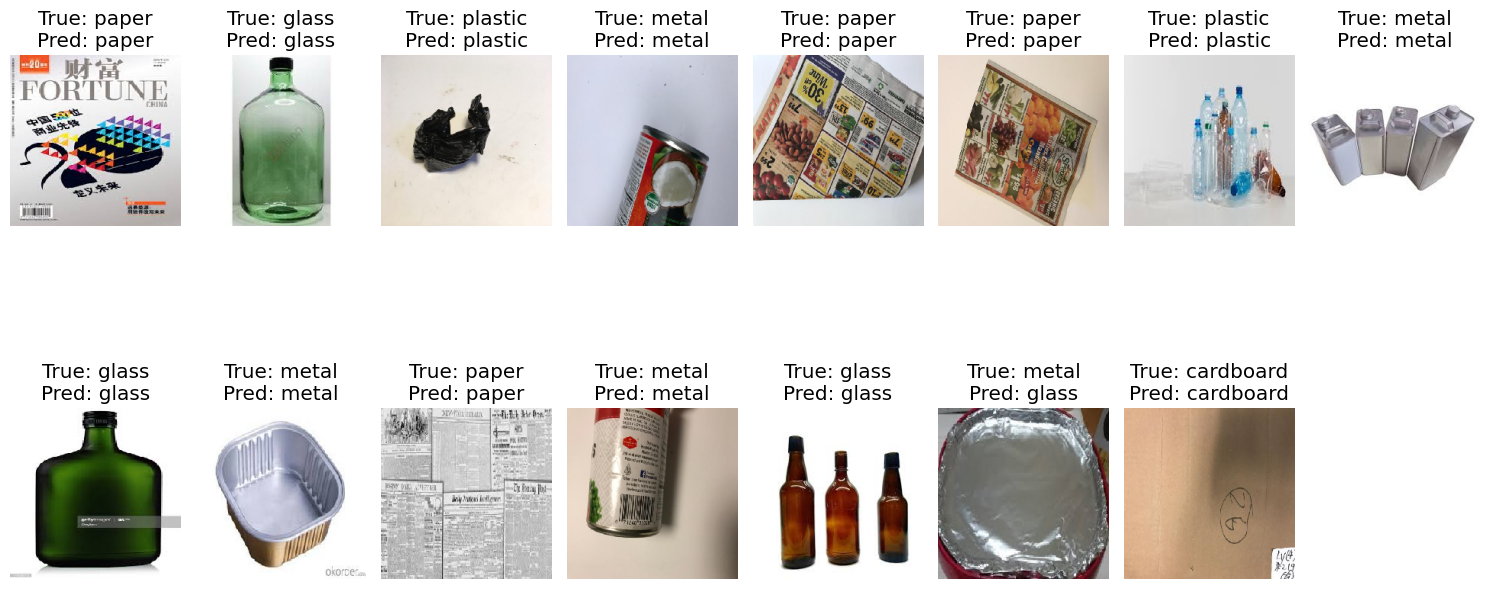

In [ ]:
def plot_predicted_images(test_df, predicted_classes, class_labels, 
                          image_size=(224, 224), num_images=6, only_misclassified=False):
    """
    Plots sample test images with their true and predicted labels.

    Args:
        test_df (pd.DataFrame): DataFrame with columns ['image_path', 'label']
        predicted_classes (array-like): Model predictions (class indices) for test_df
        class_labels (list): List mapping class indices -> class names
        image_size (tuple): Target size for displaying images
        num_images (int): Number of images to display
        only_misclassified (bool): If True, only show misclassified examples
    """
    # Ensure predictions are aligned
    true_classes = test_df['label'].values
    pred_classes = predicted_classes

    # Filter for misclassified if requested
    if only_misclassified:
        mismatches = np.where(true_classes != pred_classes)[0] if np.issubdtype(pred_classes.dtype, np.integer) else \
                     np.where(true_classes != np.array([class_labels[p] for p in pred_classes]))[0]
        if len(mismatches) == 0:
            print("No misclassified images to show ")
            return
        selected_indices = np.random.choice(mismatches, 
                                            size=min(num_images, len(mismatches)), 
                                            replace=False)
    else:
        selected_indices = np.random.choice(len(test_df), 
                                            size=min(num_images, len(test_df)), 
                                            replace=False)

    # Plot images
    plt.figure(figsize=(15, 8))
    for i, idx in enumerate(selected_indices):
        row = test_df.iloc[idx]
        img = load_img(row['image_path'], target_size=image_size)

        # Handle true label
        true_label = row['label'] if isinstance(row['label'], str) else class_labels[row['label']]
        pred_label = class_labels[pred_classes[idx]]

        plt.subplot(2, (num_images + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_predicted_images(test_df, predicted_classes, class_labels, num_images=15)

In [44]:
# Count misclassifications
correct_predictions = np.sum(predicted_classes == true_classes)
total_predictions = len(true_classes)
incorrect_predictions = total_predictions - correct_predictions

print(f"Total predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions} ({correct_predictions/total_predictions:.2%})")
print(f"Incorrect predictions: {incorrect_predictions} ({incorrect_predictions/total_predictions:.2%})")

Total predictions: 1257
Correct predictions: 1176 (93.56%)
Incorrect predictions: 81 (6.44%)


In [45]:
# Save the model
model.save('garbage_classification_model.h5')